# Leak Detection

## 1. Make Graph

Convert the `EPANET` model to a `networkx` graph

In [1]:
import os
import yaml
import time
import torch
import epynet
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from utils.epanet_loader import get_nx_graph
from utils.epanet_simulator import epanetSimulator
from utils.data_loader import battledimLoader, dataCleaner, dataGenerator, embedSignalOnGraph, rescaleSignal
from modules.torch_gnn import ChebNet
from utils.visualisation import visualise

# Runtime configuration
path_to_wdn     = './data/L-TOWN.inp'
path_to_data    = './data/l-town-data/'
weight_mode     = 'pipe_length'
self_loops      = True
scaling         = 'minmax'
task            = 'prediction'
mode            = 'n_timesteps'
n_timesteps     = 3
figsize         = (50,16)
print_out_rate  = 100               
model_name      = 'l-town-chebnet-' + task +'-' + mode + '-' + 'n_{}'.format(n_timesteps)
last_model_path = './studies/models/' + model_name + '-1.pt'
last_log_path   = './studies/logs/'   + model_name + '-1.csv'

# Import the .inp file using the EPYNET library
wdn = epynet.Network(path_to_wdn)

# Solve hydraulic model for a single timestep
wdn.solve()

# Convert the file using a custom function, based on:
# https://github.com/BME-SmartLab/GraphConvWat 
G , pos , head = get_nx_graph(wdn, weight_mode=weight_mode, get_head=True)

Get a list of node IDs with sensors

In [2]:
# Open the dataset configuration file
with open(path_to_data + 'dataset_configuration.yml') as file:

    # Load the configuration to a dictionary
    config = yaml.load(file, Loader=yaml.FullLoader) 

# Generate a list of integers, indicating the number of the node
# at which a  pressure sensor is present
sensors = [int(string.replace("n", "")) for string in config['pressure_sensors']]

Add self-loops to the sensor nodes in the graph

In [3]:
if self_loops:
    for sensor_node in sensors:             # For each node in the sensor list
        G.add_edge(u_of_edge=sensor_node,   # Add an edge from that node ...
                   v_of_edge=sensor_node,   # ... to itself ...
                   weight=1.,name='SELF')   # ... and set its weight to equal 1

## 2. Get Simulation Data

We run an EPANET simulation using the WNTR library and the EPANET
nominal model supplied with the BattLeDIM competition. <br>
With this simulation, we have a complete pressure signal for all
nodes in the network, on which the GNN algorithm is to be trained.

In [4]:
# Instantiate the nominal WDN model
nominal_wdn_model = epanetSimulator(path_to_wdn, path_to_data)

# Run a simulation
nominal_wdn_model.simulate()

# Retrieve the nodal pressures
nominal_pressure = nominal_wdn_model.get_simulated_pressure()

Populate feature vector x and label vector y from the nominal pressures. <br>
Also retrieve the scale and bias of the scaling transformation. <br>
This is so we can inverse transform the predicted values to calculate relative reconstruction errors

In [5]:
x,y,scale,bias = dataCleaner(pressure_df    = nominal_pressure, # Pass the nodal pressures
                             observed_nodes = sensors,          # Indicate which nodes have sensors
                             rescale        = scaling,          # Perform scaling on the timeseries data
                             task           = 'prediction',
                             mode           = 'n_timesteps',
                             n_timesteps    = 3)          

# Split the data into training and validation sets
x_trn, x_val, y_trn, y_val = train_test_split(x, y, 
                                              test_size    = 0.2,
                                              random_state = 1,
                                              shuffle      = False)

## 3. Get Historical Data

In [6]:
# Load the data into a numpy array with format matching the GraphConvWat problem
pressure_2018 = battledimLoader(observed_nodes = sensors,
                                n_nodes        = 782,
                                path           = path_to_data,
                                file           = '2018_SCADA_Pressures.csv',
                                rescale        = True, 
                                scale          = scale,
                                bias           = bias)

pressure_2019 = battledimLoader(observed_nodes = sensors,
                                n_nodes        = 782,
                                path           = path_to_data,
                                file           = '2019_SCADA_Pressures.csv',
                                rescale        = True, 
                                scale          = scale,
                                bias           = bias)

## 4. Load a Trained GNN Model

In [76]:
# Set the computation device as NVIDIA GPU if available else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate a Chebysev Network GNN model
model  = ChebNet(name           = 'ChebNet',
                 data_generator = None,
                 device         = device, 
                 in_channels    = np.shape(x_trn)[-1], 
                 out_channels   = np.shape(y_trn)[-1],
                 data_scale     = scale, 
                 data_bias      = bias).to(device)

In [77]:
# We offer the user the option to load the previously trained weights
model.load_model(last_model_path, last_log_path)


                Loaded previous model results...
                --------------------------------------------------
                Model has been trained for:	100 epochs
                Best validation loss:      	1.6016847697140293e-05 
                Occurred in training round:	96 


## 5. Predict a Year's worth of Data

In [78]:
def predict_pressure(graph, pressure_series, print_out_rate=100, save=True, filename='predictions.csv'):
    results = []
    elapsed_time = time.time()
    for i, partial_graph_signal in enumerate(pressure_series):
        if not i % print_out_rate:
            execution_time = time.time()
        
        results.append(model.predict(graph, partial_graph_signal))
        
        if not i % print_out_rate:
            print('Signal:\t{}\t Execution:\t{:.3f} s\t Elapsed:\t{:.3f} s'.format(i,
                                                                                   time.time()-execution_time, 
                                                                                   time.time()-elapsed_time))
    if save:
        print('-'*63+"\nSaving results to: \n{}/{}\n\n".format(os.getcwd(),filename))
        pd.DataFrame(results).to_csv(filename)
    
    return results

Disabled the following cell, so as not to overwrite the two `890 MB` prediction results for 2018-19 retrieved from the `GPU` servers

## 6. Read in Yearly Prediction and Scale Back to Original Interval

In [80]:
def read_prediction(filename='predictions.csv', scale=1, bias=0, start_date='2018-01-01 00:00:00'):
    df = pd.read_csv(filename, index_col='Unnamed: 0')
    df.columns = ['n{}'.format(int(node)+1) for node in df.columns]
    df = df*scale+bias
    df.index = pd.date_range(start='2018-01-01 00:00:00',
                             periods=len(df),
                             freq = '5min')
    return df

In [81]:
p18 = read_prediction(filename='2018_predictions.csv',
                      scale=scale,
                      bias=bias,
                      start_date='2018-01-01 00:00:00')
p19 = read_prediction(filename='2019_predictions.csv',
                      scale=scale,
                      bias=bias,
                      start_date='2019-01-01 00:00:00')

In [82]:
p18

,n1,n2,n3,n4,n5,n6,n7,n8,n9,n10,...,n773,n774,n775,n776,n777,n778,n779,n780,n781,n782
2018-01-01 00:00:00,28.563843,28.346610,28.691563,33.351311,36.294633,30.926570,25.692870,37.240399,32.526859,26.290817,...,52.279706,50.737739,51.862668,45.266405,48.526479,46.146561,46.434437,47.710390,49.492876,48.980720
2018-01-01 00:05:00,28.569100,28.352159,28.698201,33.359911,36.311322,30.932796,25.695356,37.255585,32.536177,26.295590,...,52.355217,50.824027,51.944811,45.364373,48.611222,46.223724,46.510573,47.787212,49.576410,49.065540
2018-01-01 00:10:00,28.572028,28.358178,28.705669,33.362210,36.322303,30.940453,25.697665,37.265836,32.544181,26.299438,...,52.344988,50.816680,51.936422,45.350218,48.598667,46.208728,46.500113,47.775416,49.562890,49.049333
2018-01-01 00:15:00,28.576984,28.360998,28.709813,33.369867,36.332424,30.943525,25.699312,37.277623,32.546689,26.302899,...,52.377673,50.854841,51.970471,45.399196,48.635888,46.246336,46.534199,47.811243,49.602308,49.086708
2018-01-01 00:20:00,28.576958,28.362369,28.710393,33.369062,36.333190,30.944837,25.699385,37.278253,32.546948,26.302899,...,52.285251,50.744916,51.869499,45.277959,48.539472,46.155942,46.443314,47.719445,49.502994,48.992792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 23:35:00,28.489010,28.272263,28.613451,33.283968,36.131030,30.864043,25.661555,37.068031,32.443752,26.234335,...,52.103117,50.526345,51.666946,45.036614,48.349115,45.979089,46.267072,47.539476,49.303241,48.799983
2018-12-31 23:40:00,28.493298,28.274611,28.615237,33.283914,36.133210,30.866981,25.661756,37.070284,32.446158,26.235244,...,52.068037,50.487743,51.628200,44.987303,48.310681,45.942094,46.228716,47.504992,49.263005,48.761551
2018-12-31 23:45:00,28.497439,28.280229,28.621367,33.293695,36.150824,30.872183,25.664323,37.086236,32.453623,26.240497,...,52.123505,50.553989,51.691231,45.062382,48.372224,45.997768,46.286944,47.561722,49.326965,48.824475
2018-12-31 23:50:00,28.497439,28.280393,28.621356,33.293521,36.150824,30.872042,25.664757,37.086828,32.453623,26.240869,...,52.083802,50.508030,51.645182,45.005954,48.326788,45.956838,46.246597,47.517850,49.281233,48.778827


In [13]:
(p18-p19)['n1']

2018-01-01 00:00:00    0.054829
2018-01-01 00:05:00    0.054316
2018-01-01 00:10:00    0.053390
2018-01-01 00:15:00    0.054703
2018-01-01 00:20:00    0.057279
                         ...   
2018-12-31 23:35:00    0.033135
2018-12-31 23:40:00    0.037669
2018-12-31 23:45:00    0.035704
2018-12-31 23:50:00    0.039545
2018-12-31 23:55:00    0.036543
Freq: 5T, Name: n1, Length: 105120, dtype: float64

In [14]:
max(abs(p18-p19))

'n99'

In [15]:
(p18-p19)['n99']

2018-01-01 00:00:00    0.175534
2018-01-01 00:05:00    0.159899
2018-01-01 00:10:00    0.158813
2018-01-01 00:15:00    0.155785
2018-01-01 00:20:00    0.170051
                         ...   
2018-12-31 23:35:00    1.294815
2018-12-31 23:40:00    1.316767
2018-12-31 23:45:00    1.276980
2018-12-31 23:50:00    1.306841
2018-12-31 23:55:00    1.228469
Freq: 5T, Name: n99, Length: 105120, dtype: float64

In [16]:
diff = (p18-p19).copy()

In [17]:
rank = diff.rank(axis=1,method='max',ascending=False)

In [18]:
rank.iloc[0].sort_values()

n273      1.0
n235      2.0
n129      3.0
n198      4.0
n78       5.0
        ...  
n359    778.0
n358    779.0
n22     780.0
n7      781.0
n336    782.0
Name: 2018-01-01 00:00:00, Length: 782, dtype: float64

In [19]:
diff['n273']

2018-01-01 00:00:00    0.235789
2018-01-01 00:05:00    0.214004
2018-01-01 00:10:00    0.217064
2018-01-01 00:15:00    0.211911
2018-01-01 00:20:00    0.229435
                         ...   
2018-12-31 23:35:00    1.747169
2018-12-31 23:40:00    1.769398
2018-12-31 23:45:00    1.720061
2018-12-31 23:50:00    1.760694
2018-12-31 23:55:00    1.663294
Freq: 5T, Name: n273, Length: 105120, dtype: float64

In [20]:
diff['n336']

2018-01-01 00:00:00    0.019033
2018-01-01 00:05:00    0.016684
2018-01-01 00:10:00    0.014670
2018-01-01 00:15:00    0.016864
2018-01-01 00:20:00    0.019837
                         ...   
2018-12-31 23:35:00    0.148270
2018-12-31 23:40:00    0.148136
2018-12-31 23:45:00    0.145229
2018-12-31 23:50:00    0.148308
2018-12-31 23:55:00    0.138673
Freq: 5T, Name: n336, Length: 105120, dtype: float64

Animate graph of network (?)

Create an animation

Standardise pressure difference rankings (divide by node number)

Plot, then biggest difference should be "whitest" on colormap, to darkest where diff is little.

In [34]:
p18.columns = np.arange(1,783)

## 7. Generate an Animation of the Pressure Difference

Let's create self contained code for animating the pressure differences 
We can then convert this to a Python script and deploy it on the Geneva or CPU servers.

In [56]:
import epynet
import pandas as pd
import networkx as nx
import matplotlib.animation as animation

# --------------------------
# Importing custom libraries
# --------------------------

# To make sure we don't raise an error on importing project specific 
# libraries, we retrieve the path of the program file ...
filepath = os.path.dirname(os.path.realpath(__file__))

# ... and set that as our working directory
os.chdir(filepath)

from matplotlib.animation import FuncAnimation
from utils.epanet_simulator import epanetSimulator
from utils.data_loader import dataCleaner
from utils.epanet_loader import get_nx_graph

In [57]:
# Runtime configuration
path_to_wdn     = './data/L-TOWN.inp'
path_to_data    = './data/l-town-data/'
scaling         = 'minmax'

In [58]:
# Import the .inp file using the EPYNET library
wdn = epynet.Network(path_to_wdn)

# Solve hydraulic model for a single timestep
wdn.solve()

# Convert the file using a custom function, based on:
# https://github.com/BME-SmartLab/GraphConvWat 
G , pos , head = get_nx_graph(wdn, weight_mode='unweighted', get_head=True)

In [59]:
# Instantiate the nominal WDN model
nominal_wdn_model = epanetSimulator(path_to_wdn, path_to_data)

# Run a simulation
nominal_wdn_model.simulate()

# Retrieve the nodal pressures
nominal_pressure = nominal_wdn_model.get_simulated_pressure()

In [60]:
# Open the dataset configuration file
with open(path_to_data + 'dataset_configuration.yml') as file:

    # Load the configuration to a dictionary
    config = yaml.load(file, Loader=yaml.FullLoader) 

# Generate a list of integers, indicating the number of the node
# at which a  pressure sensor is present
sensors = [int(string.replace("n", "")) for string in config['pressure_sensors']]

In [61]:
x,y,scale,bias = dataCleaner(pressure_df    = nominal_pressure, # Pass the nodal pressures
                             observed_nodes = sensors,          # Indicate which nodes have sensors
                             rescale        = scaling)          # Perform scaling on the timeseries data

In [62]:
def read_prediction(filename='predictions.csv', scale=1, bias=0, start_date='2018-01-01 00:00:00'):
    df = pd.read_csv(filename, index_col='Unnamed: 0')
    df.columns = ['n{}'.format(int(node)+1) for node in df.columns]
    df = df*scale+bias
    df.index = pd.date_range(start='2018-01-01 00:00:00',
                             periods=len(df),
                             freq = '5min')
    return df

In [63]:
p18 = read_prediction(filename='2018_predictions.csv',
                      scale=scale,
                      bias=bias,
                      start_date='2018-01-01 00:00:00')
p19 = read_prediction(filename='2019_predictions.csv',
                      scale=scale,
                      bias=bias,
                      start_date='2019-01-01 00:00:00')

In [16]:
diff = (p18-p19).copy()

In [64]:
cmap      = plt.get_cmap('hot')                                         # Generate a colourmap
pred_cmap = [cmap(diff.iloc[i].to_numpy()) for i in range(len(diff))]   # of the predicted signals

In [65]:
print(os.environ['_'])

/opt/anaconda3/envs/GSP/bin/jupyter-notebook


In [84]:
# Enable interactive plot
%matplotlib notebook
%matplotlib notebook

<IPython.core.display.Javascript object>


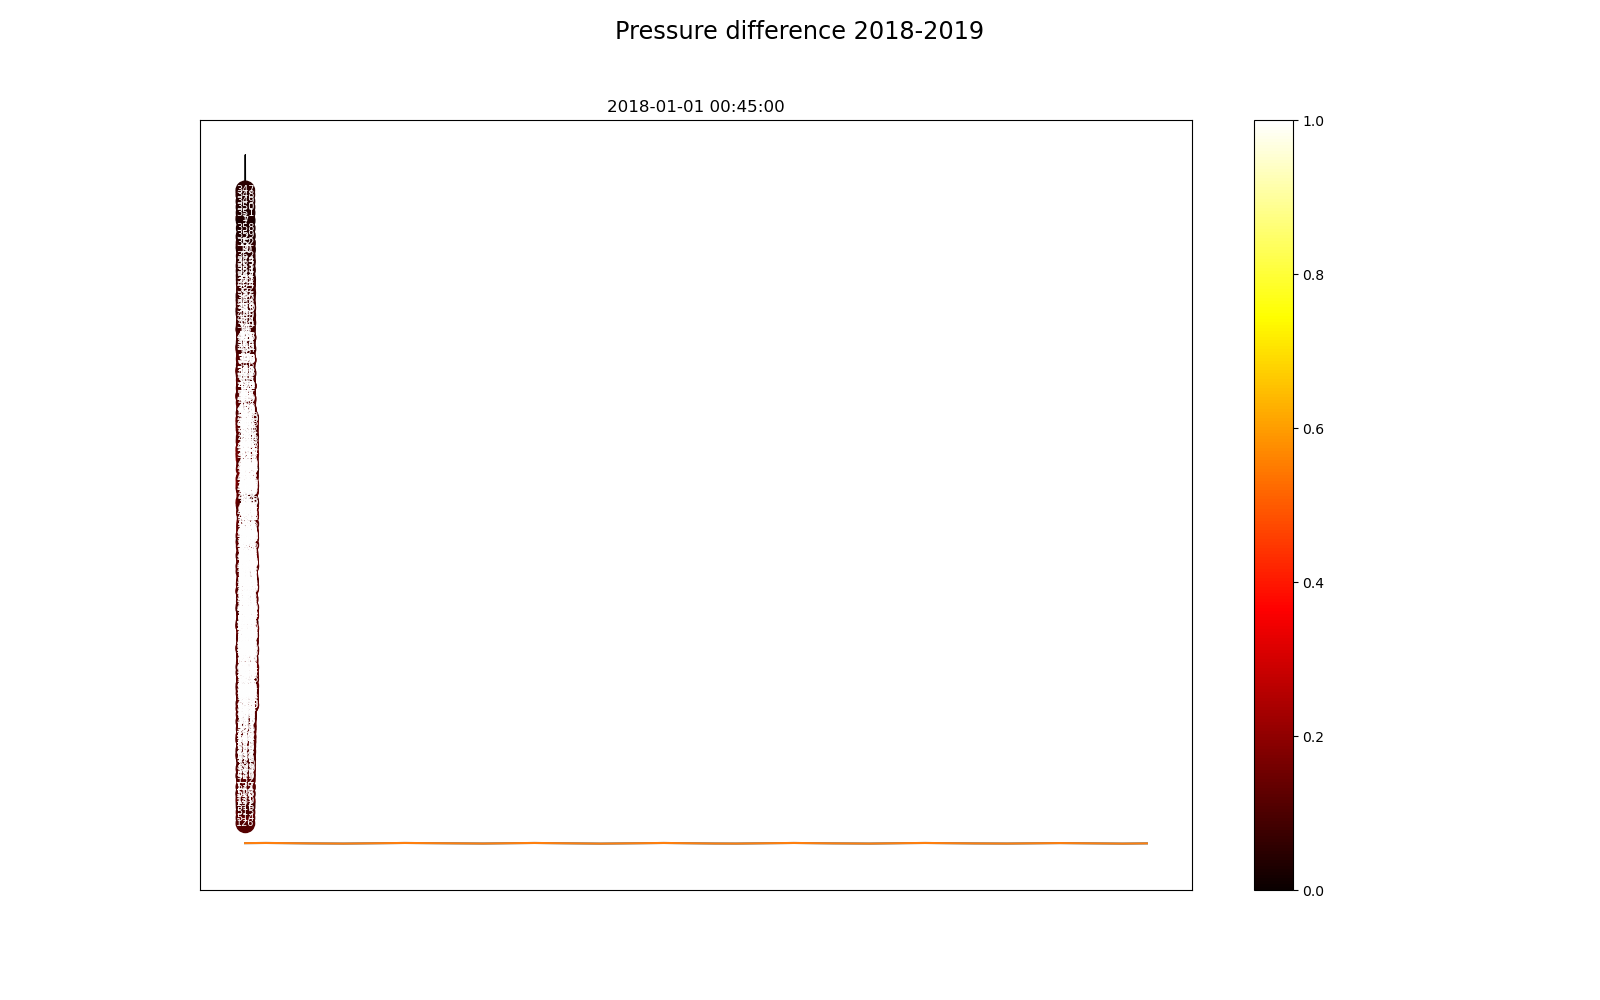

<function matplotlib.pyplot.show(block=None)>

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,10), sharex=True, sharey=True) 

# Visualise the the model using our visualisation utility
ax = visualise(G, pos=pos, color=pred_cmap[0], figsize=figsize, edge_labels=False, axis=ax, cmap=pred_cmap[0])

# Print a heading
plt.suptitle("Pressure difference 2018-2019", fontsize='xx-large')

# Initialise a colorbar
sm    = plt.cm.ScalarMappable(cmap=cmap)
sm._A = []

# Plot colorbar
plt.colorbar(sm, ax=ax)#.ravel().tolist())

def update(n, pos=pos, G=G):
    plt.cla()
    ax.set_title(diff.index[n])
    nx.draw_networkx(G, pos=pos, node_color=pred_cmap[n], with_labels=True, node_size=175, font_size=7, font_color='w')

ani = FuncAnimation(plt.gcf(), update, interval=50, frames=len(pred_cmap[:10]), repeat=False, cache_frame_data=True)

plt.rcParams['animation.ffmpeg_path'] = '/opt/anaconda3/envs/GSP/bin/ffmpeg'

# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

plt.show

#ani.save('./diff_2018-19.mp4', writer=writer)

In [95]:
nominal_pressure

,1,2,3,4,5,6,7,8,9,10,...,773,774,775,776,777,778,779,780,781,782
0,28.885649,28.229593,28.925112,33.828159,36.537888,31.185562,26.183756,37.625713,32.829617,27.756403,...,52.457668,50.842834,51.985100,45.279144,48.613106,46.187431,46.464058,47.713551,49.513973,49.027523
300,28.900486,28.244280,28.939800,33.842846,36.552296,31.200220,26.198536,37.640057,32.844303,27.771090,...,52.476357,50.860176,52.003483,45.305267,48.638573,46.213013,46.489712,47.739033,49.539490,49.053162
600,28.915424,28.259079,28.954599,33.857647,36.566822,31.214993,26.213409,37.654522,32.859100,27.785879,...,52.494904,50.877392,52.021740,45.331276,48.663929,46.238487,46.515255,47.764404,49.564884,49.078682
900,28.930391,28.273897,28.969416,33.872475,36.581398,31.229792,26.228312,37.669022,32.873928,27.800697,...,52.512928,50.894112,52.039471,45.356632,48.688644,46.263317,46.540150,47.789131,49.589645,49.103565
1200,28.945330,28.288706,28.984215,33.887299,36.595974,31.244581,26.243195,37.683544,32.888744,27.815506,...,52.530228,50.910160,52.056496,45.381069,48.712467,46.287258,46.564156,47.812969,49.613506,49.127548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603600,28.254526,27.599018,28.294537,33.197620,35.908325,30.555126,25.552855,36.996414,32.199078,27.125828,...,52.390083,50.780121,51.918594,45.184193,48.520725,46.094650,46.371037,47.621143,49.421486,48.934597
603900,28.268282,27.612644,28.308163,33.211239,35.921730,30.568724,25.566566,37.009750,32.212696,27.139463,...,52.404682,50.793671,51.932964,45.204330,48.540359,46.114368,46.390812,47.640789,49.441154,48.954361
604200,28.282366,27.626598,28.322117,33.225182,35.935429,30.582640,25.580593,37.023396,32.226639,27.153416,...,52.421234,50.809032,51.949249,45.227543,48.562996,46.137093,46.413582,47.663429,49.463799,48.977104
604500,28.296803,27.640894,28.336412,33.239471,35.949455,30.596899,25.594973,37.037357,32.240917,27.167704,...,52.438648,50.825188,51.966385,45.251743,48.586594,46.160793,46.437347,47.687035,49.487434,49.000851


<IPython.core.display.Javascript object>


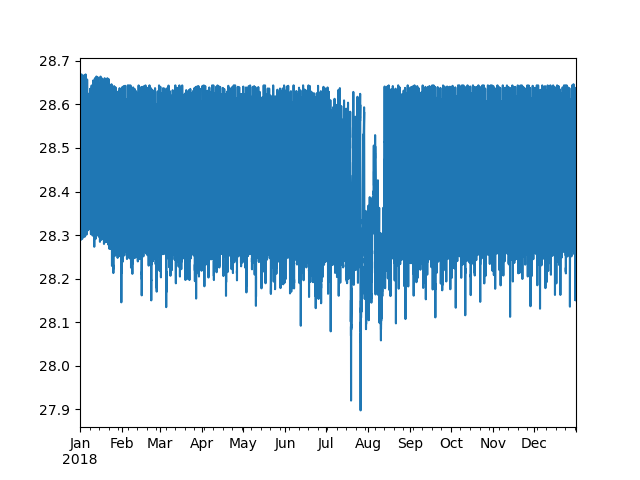

In [101]:
p18['n1'].plot()
plt.show()

In [105]:
604800/60/60/24

7.0

In [102]:
nominal_pressure

,1,2,3,4,5,6,7,8,9,10,...,773,774,775,776,777,778,779,780,781,782
0,28.885649,28.229593,28.925112,33.828159,36.537888,31.185562,26.183756,37.625713,32.829617,27.756403,...,52.457668,50.842834,51.985100,45.279144,48.613106,46.187431,46.464058,47.713551,49.513973,49.027523
300,28.900486,28.244280,28.939800,33.842846,36.552296,31.200220,26.198536,37.640057,32.844303,27.771090,...,52.476357,50.860176,52.003483,45.305267,48.638573,46.213013,46.489712,47.739033,49.539490,49.053162
600,28.915424,28.259079,28.954599,33.857647,36.566822,31.214993,26.213409,37.654522,32.859100,27.785879,...,52.494904,50.877392,52.021740,45.331276,48.663929,46.238487,46.515255,47.764404,49.564884,49.078682
900,28.930391,28.273897,28.969416,33.872475,36.581398,31.229792,26.228312,37.669022,32.873928,27.800697,...,52.512928,50.894112,52.039471,45.356632,48.688644,46.263317,46.540150,47.789131,49.589645,49.103565
1200,28.945330,28.288706,28.984215,33.887299,36.595974,31.244581,26.243195,37.683544,32.888744,27.815506,...,52.530228,50.910160,52.056496,45.381069,48.712467,46.287258,46.564156,47.812969,49.613506,49.127548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603600,28.254526,27.599018,28.294537,33.197620,35.908325,30.555126,25.552855,36.996414,32.199078,27.125828,...,52.390083,50.780121,51.918594,45.184193,48.520725,46.094650,46.371037,47.621143,49.421486,48.934597
603900,28.268282,27.612644,28.308163,33.211239,35.921730,30.568724,25.566566,37.009750,32.212696,27.139463,...,52.404682,50.793671,51.932964,45.204330,48.540359,46.114368,46.390812,47.640789,49.441154,48.954361
604200,28.282366,27.626598,28.322117,33.225182,35.935429,30.582640,25.580593,37.023396,32.226639,27.153416,...,52.421234,50.809032,51.949249,45.227543,48.562996,46.137093,46.413582,47.663429,49.463799,48.977104
604500,28.296803,27.640894,28.336412,33.239471,35.949455,30.596899,25.594973,37.037357,32.240917,27.167704,...,52.438648,50.825188,51.966385,45.251743,48.586594,46.160793,46.437347,47.687035,49.487434,49.000851


<IPython.core.display.Javascript object>


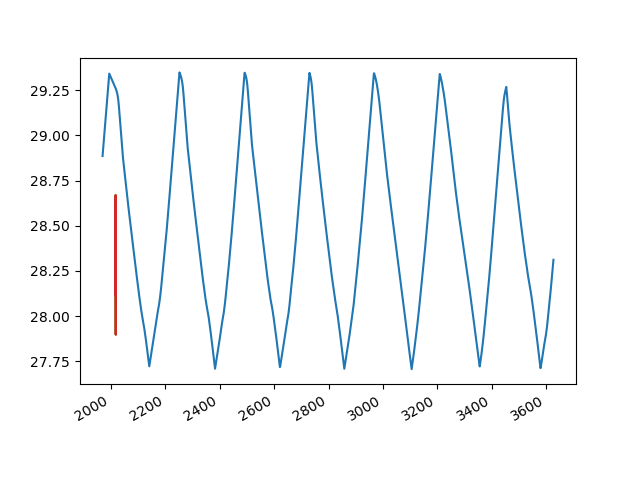

In [94]:
nominal_pressure[1].plot()
plt.show()